# Kernel k-means

## Informal Problem Definition
$k$-means can Only Identify Convex Clusters

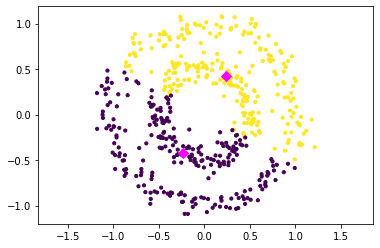

In [1]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
epsilon=0.08
D, labels = datasets.make_circles(n_samples=500, factor=.5, noise=epsilon)
kmeans = KMeans(n_clusters=2,n_init=1)
kmeans.fit(D)
plt.scatter(D[:, 0], D[:, 1], c=kmeans.labels_, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='magenta', s=50, marker = 'D')
plt.axis('equal')
plt.show()

The cluster-separating boundary between two centroids is always linear. What do we do if we have nonlinearly separated clusters?

Feature Transformation and Kernel Trick
Use a feature transformation to map points to a space where clusters are linearly separable: 
$$\vvec{x}\rightarrow \phi(\vvec{x}).$$
    
Problem: Computing $\phi(\vvec{x})$ for every data point might be costly or impossible, $\phi(\vvec{x})$ might be infinite-dimensional (see RBF kernel).

Solution: We don't need $\phi$, we just need the inner product 
$\phi(\vvec{x})^\top\phi(\vvec{y})$

Defining for $D\in\mathbb{R}^{n\times d}$ the row-wise applied feature transformation
$${\bm\phi}(D)= \begin{pmatrix}--& {\bm\phi}(D_{1\cdot }) & --\\ &\vdots&\\ --&{\bm\phi}(D_{n\cdot})&--\end{pmatrix},$$
the kernel matrix is given by
$$ K = {\bm\phi}(D){\bm\phi}(D)^\top\in\mathbb{R}^{n\times n}.$$

## Formal Problem Definition
`````{admonition} Task (Kernel $k$-means)
:class: tip
**Given** a data matrix $D\in\mathbb{R}^{n\times d}$, a feature transformation $\phi:\mathbb{R}^{d}\rightarrow \mathbb{R}^p$ mapping into a $p$-dimensional feature space, where $p\in\mathbb{N}\cup\{\infty\}$, and the number of clusters $r$.      
**Find** clusters indicated by the matrix $Y\in\mathbb{1}^{n\times r}$ which minimize the within cluster scatter in the transformed feature space
\begin{align}
\min_{Y} \|{\bm\phi}(D)-YX^\top\|^2 \text{  s.t. } X= {\bm\phi}(D^\top) Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r} \label{eq:kernelKMPhi}
\end{align}
**Return** the clustering $Y\in\mathbb{1}^{n\times r}$
`````


## Optimization
If we want to apply the kernel trick, then we need to state the kernel $k$-means objective with respect to the inner product of data points.
```{prf:theorem} $k$-means trace objective
Given a data matrix $D\in\mathbb{R}^{n\times d}$,
the following objectives are equivalent $k$-means objectives:
\begin{align}
&\min_{Y} \lVert D-YX^\top\rVert^2 \text{  s.t. } X= D^\top Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r} \label{eq:km}\\
&\max_{Y} \tr(Z^\top DD^\top Z)\qquad\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} \label{eq:kmeansTr}
\end{align}
```
````{toggle}
```{prf:proof}
For ${\color{magenta}X=D^\top Y(Y^\top Y)^{-1}}$, we have
\begin{align*}
    &\lVert D-Y{\color{magenta}X^\top}\rVert^2 \\
    &= \lVert D\rVert^2 -2\tr(D^\top Y{\color{magenta}X^\top} )+ \lVert Y{\color{magenta}X^\top}\rVert^2 &\text{(binomial formula)}\\
    &= \lVert D\rVert^2 -2\tr(D^\top Y{\color{magenta}X^\top})+ \tr( {\color{magenta}X}Y^\top Y {\color{magenta}X^\top})&\text{(def. Fro-norm by $\tr$)}\\
    &= \lVert D\rVert^2 -2\tr({\color{magenta}X}Y^\top D)+ \tr( {\color{magenta}X}Y^\top Y {\color{magenta}(Y^\top Y)^{-1}Y^\top D})&\text{(def. $X$)}\\
    &= \lVert D\rVert^2 -\tr({\color{magenta}D^\top Y(Y^\top Y)^{-1}}Y^\top D)&\text{($Y^\top Y(Y^\top Y)^{-1} =I$)}\\
    &= \lVert D\rVert^2 -\tr( (Y^\top Y)^{-1/2}Y^\top DD^\top Y (Y^\top Y)^{-1/2})&\text{(cycling property $\tr$)}
\end{align*}
As a result, the objective function of $k$-means is equal to
\begin{align*}
    \lVert D-Y{\color{magenta}X^\top}\rVert^2
    &= \lVert D\rVert^2 -\tr( (Y^\top Y)^{-1/2}Y^\top DD^\top Y (Y^\top Y)^{-1/2})\\
    &=\lVert D\rVert^2 -\tr( (Z^\top DD^\top Z),
\end{align*}
for $Z =Y (Y^\top Y)^{-1/2} $.
Minimizing the term on the left is equivalent to minimizing the negative trace term on the right, which is equivalent to maximizing the trace term on the right.
```
````
Interpretation: Clusters are now defined with respect to the inner product similarity:
$$sim(i,j) = D_{i\cdot}D_{j\cdot}^\top =\cos(\sphericalangle(D_{i\cdot},D_{j\cdot}))\lVert D_{i\cdot}\rVert\lVert D_{j\cdot}\rVert$$
Points within one cluster need to be similar:
$$\tr(Z^\top DD^\top Z)=\sum_{s=1}^r\frac{Y_{\cdot s}^\top DD^\top Y_{\cdot s}}{\lvert Y_{\cdot s}\rvert}
=\sum_{s=1}^r\frac{1}{\lvert \mathcal{C}_{s}\rvert}\sum_{i,j\in\mathcal{C}_s} D_{i\cdot}D_{j\cdot}^\top$$

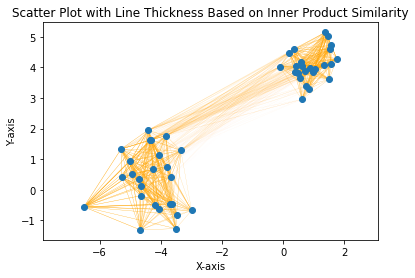

In [2]:
import numpy as np

# Example points
epsilon=0.00
D, labels = datasets.make_blobs(n_samples=50,centers=2, cluster_std=[epsilon + 0.5, epsilon + 0.8],random_state=3)
points = D

# Calculate Euclidean distances between consecutive points
distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))

# Normalize distances for line thickness
thickness = D@D.T  # Scale for visualization purposes
#thickness = thickness- np.min(thickness)
thickness = thickness/ np.max(thickness)/2

# Create the scatter plot
plt.scatter(points[:, 0], points[:, 1], zorder=5)

# Plot lines with varying thickness
for i in range(len(points) - 1):
    for j in range(i+1,len(points)):
        if thickness[i,j]>0:
            plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], linewidth=thickness[i,j], color='orange', zorder=1)

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Line Thickness Based on Inner Product Similarity')
plt.axis('equal')
plt.show()


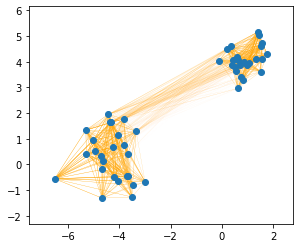

In [3]:
from scipy import sparse
from matplotlib.collections import LineCollection
epsilon=0.00
D, labels = datasets.make_blobs(n_samples=50,centers=2, cluster_std=[epsilon + 0.5, epsilon + 0.8],random_state=3)

A=D@D.T
A = A/ np.max(A)/2
A *= np.tri(*A.shape)
A*= (A>0)
sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(np.min(D[:,0])-1, np.max(D[:,0])+1)
ax.set_ylim(np.min(D[:,1])-1, np.max(D[:,1])+1)
ax.set_aspect("equal") 

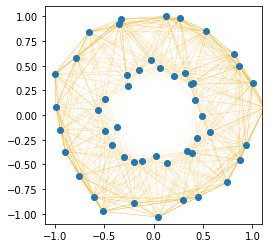

In [4]:
from scipy import sparse
epsilon=0.05
D, labels = datasets.make_circles(n_samples=50, factor=.5, noise=epsilon)

A=D@D.T
A = A/ np.max(A)/2
A *= np.tri(*A.shape)
A*= (A>0)
sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal") 

```{prf:theorem} Equivalent kernel $k$-means objectives
Given the kernel matrix $K={\bm\phi}(D){\bm\phi}(D)^\top$,
the following objectives are equivalent:
\begin{align}
&\min_{Y} \|{\bm\phi}(D)-YX^\top\|^2 \text{  s.t. } X= {\bm\phi}(D^\top) Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r} \label{eq:kernelKMPhi1}\\
&\max_{Y} \tr(Z^\top K Z)\qquad\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} \label{eq:kernelKMtr}
\end{align}
```
Problem: We do not know how to optimize Eq. \eqref{eq:kernelKMtr}, we only know how to optimize Eq. \eqref{eq:kernelKMPhi1}, but we do not want to compute $\phi$!        

Idea: We go the other way round: from the kernel matrix to the inner product.
```{prf:theorem} Eigendecomposition of symmetric matrices
For every symmetric matrix $K=K^\top\in\mathbb{R}^{n\times n}$ there exists an orthogonal matrix $V\in\mathbb{R}^{n\times n}$ and a diagonal matrix $\Lambda=\diag(\lambda_1,\ldots,\lambda_n)$ where $\lvert \lambda_1\rvert\geq \ldots \geq \lvert \lambda_n\rvert$ such that
    $$K=V\Lambda V^\top$$
```
Every symmetric matrix $K\in\mathbb{R}^{n\times n}$ has a symmetric decomposition $K=A^\top A$ if and only if the eigenvalues of $K$ are nonnegative. 

This is equivalent to $K$ being positive semi-definite.
Kernel matrices are positive semi-definite!

```{prf:theorem} Equivalent kernel $k$-means objectives
Given a kernel matrix and its symmetric decomposition $K=AA^\top$,
the following objectives are equivalent:
\begin{align}
&\min_{Y}\ \|A-YX^\top\|^2 &\text{ s.t. } X= A^\top Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r}\label{eq:kmeansA} \\
&\max_{Y}\ \tr(Z^\top K Z)&\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} 
\end{align}
```
Algorithm Idea: Use the objective in Eq.~\eqref{eq:kmeansA}: compute a symmetric decomposition $AA^\top=K$ by means of the eigendecomposition $A=V\Lambda^{1/2}$ and run $k$-means on $A$.

```{prf:algorithm} kernel k-means

**Input**: kernel matrix $K$, number of clusters $r$
1. $(V,\Lambda) \gets$`Eigendecomposition`$K$
2. $A\gets V\Lambda^{1/2}$ ($AA^\top=K$)
3. $(X,Y)\gets$`kMeans`$(A,r)$    
3. **return** $Y$
```
Let's try this kernel $k$-means idea on the two circles dataset. 
$$K_{ij}=\exp\left(-\epsilon\lVert D_{i\cdot} -D_{j\cdot}\rVert^2\right)$$

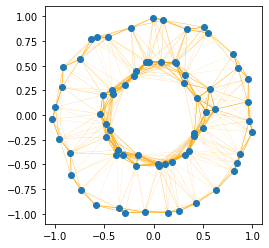

In [5]:
from scipy import sparse
epsilon=0.05
D, labels = datasets.make_circles(n_samples=70, factor=.5, noise=epsilon)

A=np.exp(-8*(np.sum(D**2,1).reshape(-1,1)  - 2* D@D.T + np.sum(D.T**2,0)))
A = A/ np.max(A)
A *= np.tri(*A.shape)
A*= (A>0.08)
sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")

We apply $k$-means on the matrix $V\Lambda^{1/2}$ and obtain a perfect clustering for a suitable choice of $\epsilon=3$ as depicted below: 

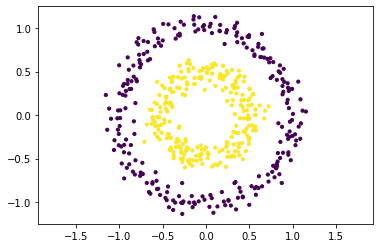

In [6]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

D, labels = datasets.make_circles(n_samples=500, factor=.5, noise=0.08)
K= rbf_kernel(D, D,gamma=3)
lambdas, V = np.linalg.eig(K)
kmeans = KMeans(n_clusters=2,n_init=1)
A = np.abs(V)@np.diag(np.abs(lambdas)**(1/2))
kmeans.fit(A)
plt.scatter(D[:, 0], D[:, 1], c=kmeans.labels_, s=10)
plt.axis('equal')
plt.show()

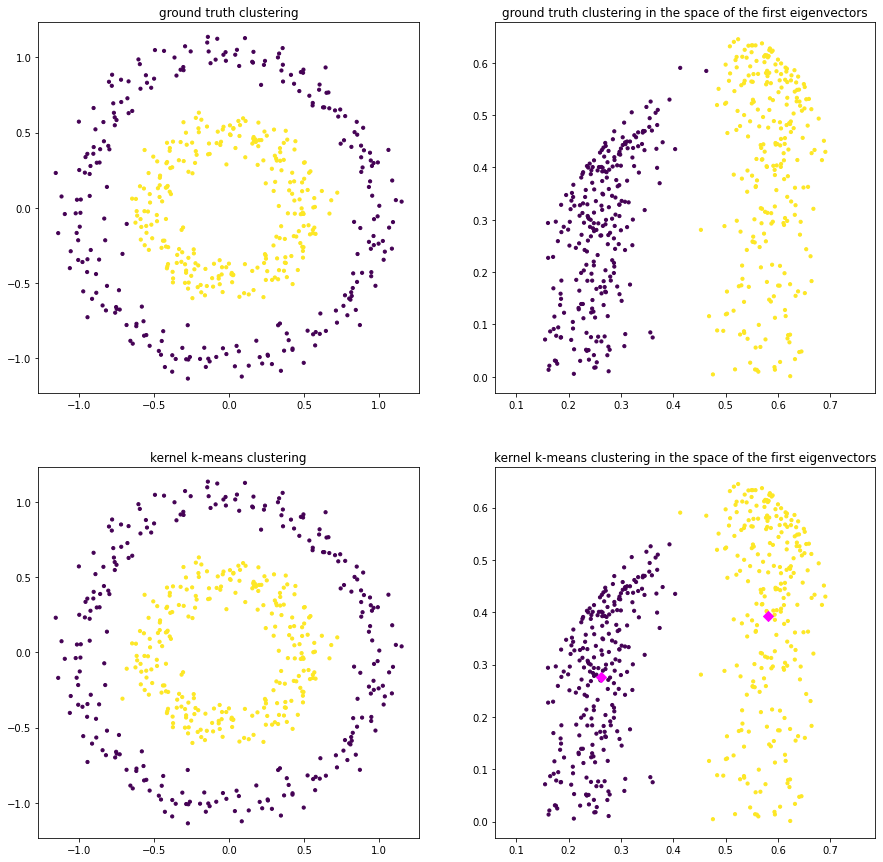

In [7]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.scatter(D[:, 0], D[:, 1], s=10, c=labels) 
plt.title("ground truth clustering")
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(A[:, 0], A[:, 1], s=10, c=labels) 
plt.title("ground truth clustering in the space of the first eigenvectors")
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.scatter(D[:, 0], D[:, 1], s=10, c=kmeans.labels_) 
plt.title("kernel k-means clustering")
plt.axis('equal')

plt.subplot(2, 2, 4)
plt.scatter(A[:, 0], A[:, 1], s=10, c=kmeans.labels_) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='magenta', s=50, marker = 'D')
plt.title("kernel k-means clustering in the space of the first eigenvectors")
plt.axis('equal')
plt.show()

Ok, so in theory we have a method to solve kernel $k$-means, but in practice this method is not often employed. Drawbacks of kernel $k$-means is a lack of robustness and the requirement of a full eigendecomposition. A related method based on a graph representation of the data facilitates nonconvex clustering based on a truncated eigendecomposition.